In [1]:
#imports

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import re
 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import f1_score

In [2]:
# load data sets
train_df = pd.read_csv('train_set.csv')
test_df = pd.read_csv('test_set.csv')

In [3]:
#peek into data
train_df.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [4]:
#
print('Number of training records: {}'. format(len(train_df)))
print('Number of unique labels: {}'.format(train_df.nunique()[0]))
print('Number of null values in the dataset: {}'.format(train_df.isnull().sum()[0]))
print('\nnumber of records per label:')
print(train_df['lang_id'].value_counts())

Number of training records: 33000
Number of unique labels: 11
Number of null values in the dataset: 0

number of records per label:
xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64


The dataset is pefectly balanced as there are equal propotions of datasets per label and there are no missing values.

### Data Cleaning


Remove noise in data.

In [5]:
#clean data

def clean_data(df, column):
    df_clean = df.copy()
    
    # lower case all letters
    df_clean[column] = df_clean[column].str.lower()

    #remove puntuations, urls and @
    df_clean[column] = df_clean[column].apply(lambda text: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text))
    return df_clean

train_clean_1 = clean_data(train_df, 'text') 

#### EDA

In [6]:
#group by language class

lan_class_collection = {}

# group datasets by language and store each group dataset in a dictionary
def group_lang(df, column, store):
    df_group = df.copy()
    lan_class = df_group.groupby(column)
    lan_list = df_group[column].value_counts().index.to_list()
    for l in lan_list:
        store[l] = lan_class.get_group(l)
    return lan_class_collection

# tokenise sentences into token of words
def text_to_words(df, column):
    df_mod = df.copy()
    df_mod[column] = df_mod[column].apply(lambda sentance: [word for word in sentance.split()])
    return df_mod

group_lang(train_clean_1, 'lang_id', lan_class_collection)
lan_class_collection['tso']

,lang_id,text
16,tso,migingiriko ya cbnrm hinkwayo yi katsa ku tumb...
22,tso,u lava yini laha he mufana va xi vutisa hi afr...
33,tso,endla leswaku swakudya leswi tolovelekeke ngop...
38,tso,a ku tsundzuxa huvo eka nhlayo leyi pimiweke y...
46,tso,psoriasis vadzahi va na kwalomu ka mbirhi ku y...
...,...,...
32887,tso,hi ku ya hi xiyenge xa a ku fika eka e nawu wa...
32931,tso,swiringanyeto leswi tisiweke swi fanele ku lun...
32942,tso,ku kombisa mutirhisi wa patu leswaku a nga ngh...
32955,tso,tlhelo leri nghenisaku mholovo eka va komiti y...



			Word Frequency Per Language



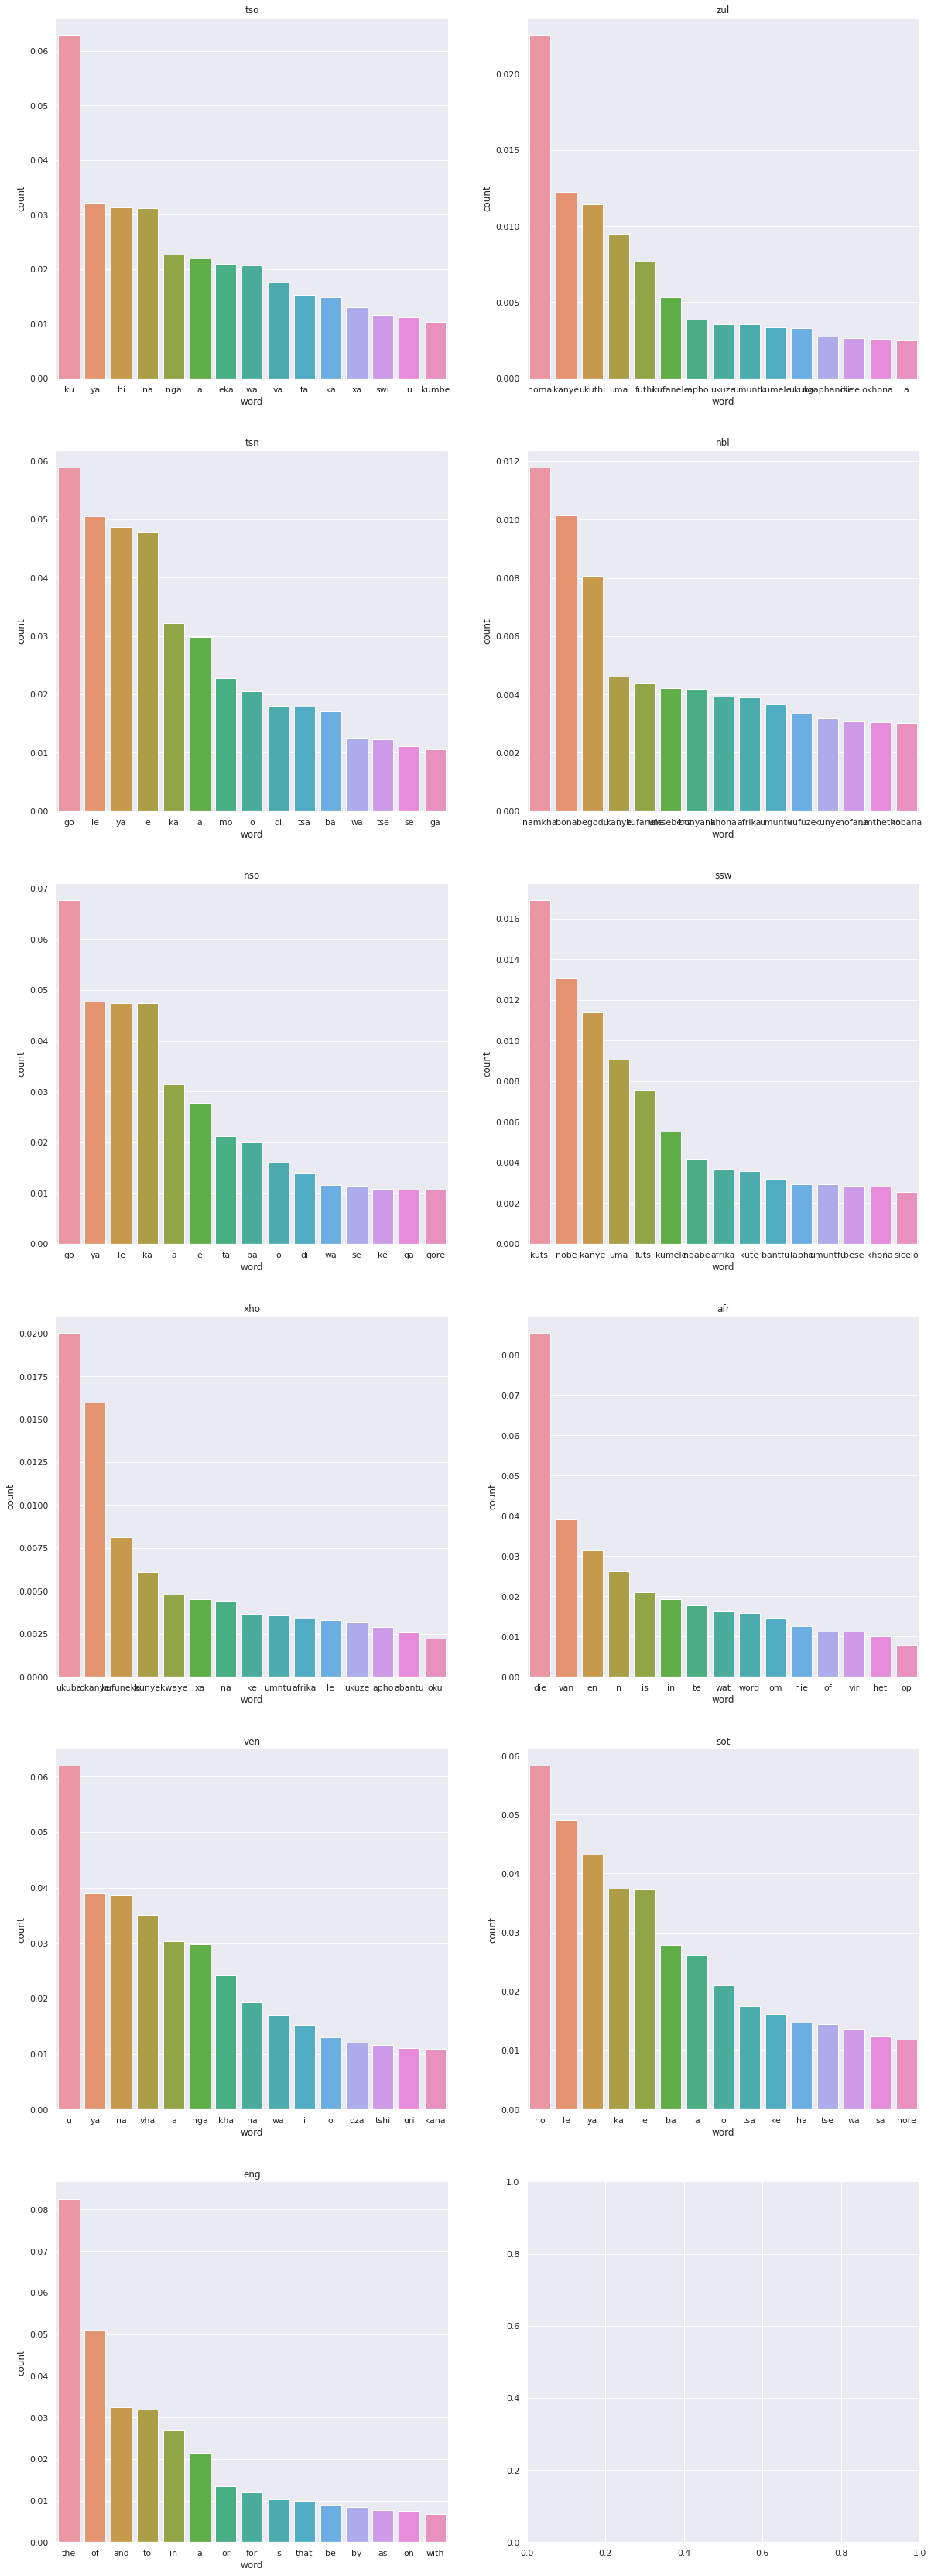

In [9]:
# word frequency per language looking at the most frequent words in a language

wf_collection = {}
for k, v in lan_class_collection.items():
    wf_collection[k] = pd.Series(' '.join(v.text).split()).value_counts(normalize=True).to_frame().reset_index()
    wf_collection[k] = wf_collection[k].rename(columns= {0: 'count', 'index':'word'})



fig, ax =plt.subplots(6,2)
sns.set(rc={"figure.figsize":(20, 60)})
i = 0
for k, v in wf_collection.items():
    v =  v.nlargest(columns='count', n=15)
    sns.barplot(data=v, ax=ax.flatten()[i], x='word', y='count').set(title=k)
    i = i + 1
print("\n\t\t\tWord Frequency Per Language\n")

NameError: name 'wf_collection' is not defined

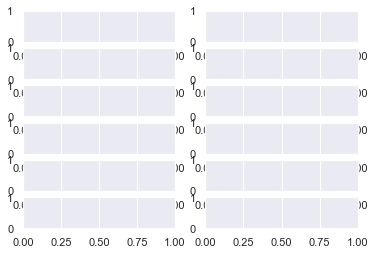

In [7]:
fig, ax =plt.subplots(6,2)
sns.set(rc={"figure.figsize":(20, 60)})
i = 0
for k, v in wf_collection.items():
    v =  v.nsmallest(columns='count', n=15)
    sns.barplot(data=v, ax=ax.flatten()[i], x='word', y='count').set(title=k)
    i = i + 1
print("\n\t\t\tWord Frequency Per Language\n")

#### Feature Engineering




In [8]:
X = train_clean_1.drop('lang_id', axis = 1)
y = train_clean_1[['lang_id']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state = 42)

In [9]:

tfidfvec = TfidfVectorizer(max_features=1000, min_df=0.00002, ngram_range=(1,3))

X_train_Tfidf_df = tfidfvec.fit_transform(X_train['text']).toarray()
X_train_Tfidf_df = pd.DataFrame(X_train_Tfidf_df)
X_test_Tfidf_df = tfidfvec.transform(X_test['text']).toarray()
X_test_Tfidf_df = pd.DataFrame(X_test_Tfidf_df)

#### Training models

In [10]:
model_g = GaussianNB()
model_g.fit(X_train_Tfidf_df, y_train['lang_id'])

GaussianNB()

In [12]:
y_pred = model_g.predict(X_test_Tfidf_df)
f1_score(y_test, y_pred, average='micro')

0.9354545454545454

In [13]:
model = LogisticRegression(multi_class='ovr')
model.fit(X_train_Tfidf_df, y_train['lang_id'])
yhat = model.predict(X_test_Tfidf_df)

In [14]:
f1_score(y_test, yhat, average='micro')

0.9584848484848486

In [15]:
# define model
model = SVC(decision_function_shape='ovr')
# fit model
model.fit(X_train_Tfidf_df, y_train['lang_id'])
# make predictions
yhat = model.predict(X_test_Tfidf_df)
f1_score(y_test, yhat, average='micro')

0.9610606060606061

In [16]:
test_clean = clean_data(test_df, 'text')
X_test_Tfidf_df = tfidfvec.transform(test_clean['text']).toarray()
X_test_Tfidf_df = pd.DataFrame(X_test_Tfidf_df)

In [17]:
y_pred = model.predict(X_test_Tfidf_df)
y_pred

array(['nbl', 'nbl', 'ven', ..., 'sot', 'sot', 'ssw'], dtype=object)

In [18]:

submission = pd.DataFrame(
    {'index': test_df['index'].tolist(),
     'lang_id': y_pred.tolist()
    })
submission.head()

,index,lang_id
0,1,nbl
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr


In [19]:
submission.to_csv("submission.csv", index=False)